In [1]:
import supereeg as se
import pandas as pd
import numpy as np
import os
import hypertools as hyp
import plot as plot
import matplotlib
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting as ni_plt
import scipy.stats as stats
import scipy.spatial as spatial

In [2]:
def plot_density(df, X, Y, outfile = None):
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    sns.set_style("white")
    mybins =np.linspace(0, .02, 200)
    g = sns.JointGrid(X, Y, df, xlim=[0,.02],ylim=[-1,1])
    g.ax_marg_x.hist(df[X], bins=mybins, color = 'k', alpha = .3)
    g.ax_marg_y.hist(df[Y], bins=np.arange(-1, 1, .01), orientation='horizontal', color = 'k', alpha = .3)
    #g.ax_marg_x.set_xscale('log')
    g.ax_marg_x.set_xscale('linear')
    g.ax_marg_y.set_yscale('linear')
    g.plot_joint(plt.scatter, color='black', edgecolor='black', alpha = .6)
    ax = g.ax_joint
    left, width = .05, .5
    bottom, height = .1, .5
    rstat = stats.pearsonr(df[X], df[Y])
    ax.text(left, bottom, 'r = ' + str(np.round(rstat[0],2)) + '   p < '+ str(10**-10),
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes, fontsize=18)
    ax.set_xlabel("Density", fontsize=21)
    ax.set_ylabel("Correlation", fontsize=21)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_xscale('linear')
    ax.set_yscale('linear')

    plt.tight_layout()

    if not outfile is None:
        plt.savefig(outfile)
    else:
        plt.show()
        

def density_within_r(locs, r):
    point_tree = spatial.cKDTree(locs)
    density_pyfr = np.array([])
    
    for l in locs: 
        density_pyfr = np.append(density_pyfr, np.divide(len(point_tree.query_ball_point(l, r)), np.shape(locs)[0]))
        
    return density_pyfr

In [3]:
fig_dir = '/Users/lucyowen/repos/supereeg_paper/paper_figs/density'

In [4]:
r = 20

In [5]:
fig_count = 0

# PyFR analysis

In [6]:
pyfr_across = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/pyfr/pyfr_across.csv', index_col=0)
pyfr_within = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/pyfr/pyfr_within.csv', index_col=0)

## Merge dataframes

In [7]:
pyFR_df = pd.merge(pyfr_across, pyfr_within, on=['Subject', 'R'])
pyFR_df.dropna(inplace=True)
pyFR_df.rename(columns={"Correlation_x":"Correlation_Across", "Correlation_y":"Correlation_Within"}, inplace=True)
e_corrs = pd.DataFrame()
e_corrs['across'] = pyFR_df['Correlation_Across']
e_corrs['within'] = pyFR_df['Correlation_Within']
e_corrs['Subject'] = pyFR_df['Subject']
e_corrs['R'] = pyFR_df['R']

## Compile pyfr locations and across correlations

In [8]:
pyfr_locs = plot.compile_df_locs(e_corrs['R'])
corr_pyfr_locs = np.atleast_2d(e_corrs['across'])

## Find locations within 10 

In [9]:
e_corrs['Density'] = density_within_r(pyfr_locs, r)

In [10]:
e_corrs.head()

,across,within,Subject,R,Density
0,0.845001,0.640388,FR190,[-63.64 -21.93 5.37],0.026631
1,0.861388,0.640299,CH013,[-48.48 38.4 17.26],0.028071
2,0.665373,0.519872,CH048,[ 49.49 -34.7 35.17],0.015355
3,0.640677,0.445660,TJ019,[ 65.66 -67.29 25.83],0.011756
4,0.764366,0.504311,FR050,[-36.36 -1.81 59.76],0.013916


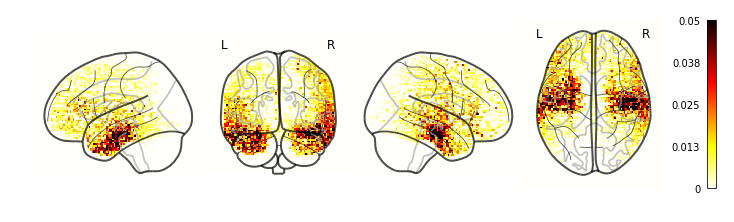

In [11]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.interp_density(pyfr_locs, np.atleast_2d(density_within_r(pyfr_locs, 20)), width=2, vox_size=2, outfile=outfile)

In [12]:
### still same negative correlation with the new way 
rstat = stats.pearsonr(e_corrs['Density'], plot.r2z(e_corrs['across']))
print(rstat)

(-0.07110589810746443, 4.32665705810839e-06)


In [13]:
### still same negative correlation with the new way 
rstat = stats.pearsonr(e_corrs['Density'], plot.r2z(e_corrs['within']))
print(rstat)

(0.025042921714367006, 0.10597743358180926)


<Figure size 1332x756 with 0 Axes>

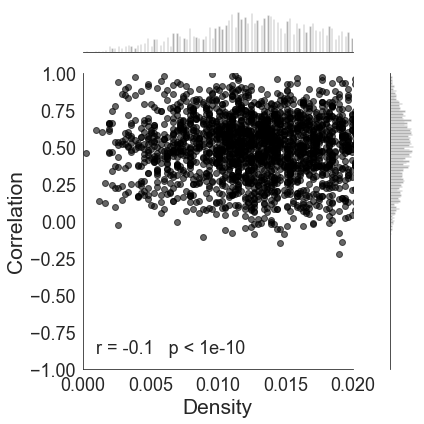

In [14]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot_density(e_corrs, 'Density', 'across', outfile=outfile)

## Find density and correlation across vs within

In [15]:
grouped_results = e_corrs.groupby('Subject')['across','within'].mean()

pyfr_locs = plot.compile_df_locs(e_corrs['R'])
corr_pyfr_locs = np.atleast_2d(e_corrs['across'])

corr_across_subject = np.array([])
corr_within_subject = np.array([])
R_locs = []
bo_locs = []
subj_by_subject = np.array([])
density_across_pyfr = np.array([])
density_within_pyfr = np.array([])

for s in grouped_results.index:


    other_locs = plot.compile_df_locs(e_corrs['R'][e_corrs['Subject'] != s])
    within_locs = plot.compile_df_locs(e_corrs['R'][e_corrs['Subject'] == s])
    
    other_tree = spatial.cKDTree(other_locs)
    within_tree = spatial.cKDTree(within_locs)

    bo_locs = []
    
    
    
    for l in plot.compile_df_locs(e_corrs['R'][e_corrs['Subject'] == s]):
    
        if bo_locs == []:
            bo_locs = l 
        else:

            bo_locs = np.vstack((bo_locs, l))

        density_across_pyfr = np.append(density_across_pyfr, np.divide(len(other_tree.query_ball_point(l, r)), other_locs.shape[0]))

        density_within_pyfr = np.append(density_within_pyfr, np.divide(len(within_tree.query_ball_point(l, r)), within_locs.shape[0]))

        loc_in_R = se.helpers.get_rows(pyfr_locs, l)
        
        across_corr = e_corrs['across'].iloc[loc_in_R]
        within_corr = e_corrs['within'].iloc[loc_in_R]
        
        corr_across_subject = np.append(corr_across_subject, across_corr)
        corr_within_subject = np.append(corr_within_subject, within_corr)

    subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(bo_locs)[0]))
    
    if R_locs == []:

        R_locs = bo_locs 

    else:

        R_locs = np.vstack((R_locs, bo_locs))




density_pyfr_df = pd.DataFrame()
density_pyfr_df['Correlation_Across'] = plot.r2z(corr_across_subject)
density_pyfr_df['Correlation_Within'] = plot.r2z(corr_within_subject)
density_pyfr_df['Density_Across'] = density_across_pyfr
density_pyfr_df['Density_Within'] = density_within_pyfr
density_pyfr_df['Subject'] = subj_by_subject

## negative correlation across density and recon accruacy

In [16]:
rstat = stats.pearsonr(density_pyfr_df['Density_Across'], density_pyfr_df['Correlation_Across'] )
print(rstat)

(-0.0769505403409969, 6.564746483933552e-07)


## but positive correlation across density and recon accruacy

In [17]:
rstat = stats.pearsonr(density_pyfr_df['Density_Within'], density_pyfr_df['Correlation_Across'] )
print(rstat)

(0.2048825327041378, 9.647539682547903e-41)


## slight positive within density and within correlation

In [18]:
rstat = stats.pearsonr(density_pyfr_df['Density_Within'], density_pyfr_df['Correlation_Within'] )
print(rstat)

(0.08808838004001908, 1.2239227154777536e-08)


## plot density for all

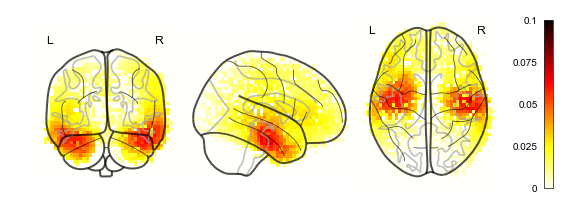

In [19]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_within_r(pyfr_locs, 20)), locs=pyfr_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.1, vmin=0)
plt.savefig(outfile)

## plot density across 

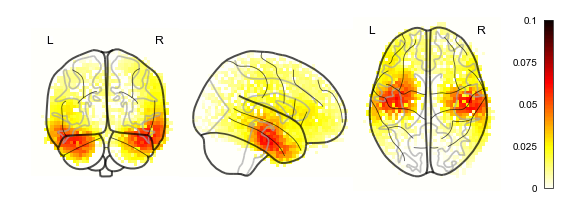

In [20]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_across_pyfr), locs=R_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.1, vmin=0)
plt.savefig(outfile)

## plot density within

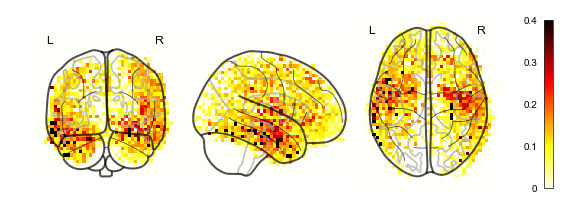

In [21]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_within_pyfr), locs=R_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.4, vmin=0)
plt.savefig(outfile)

# RAM

In [22]:
W_a_a = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/within/a_sub-a_exp.csv', index_col=0)
W_a_a.name = 'W_a_a'
W_a_all = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/within/a_sub-all_exp.csv', index_col=0)
W_a_all.name = 'W_a_all'
W_a_w = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/within/a_sub-w_exp.csv', index_col=0)
W_a_w.name = 'W_a_w'
W_w_a = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/within/w_sub-a_exp.csv', index_col=0)
W_w_a.name = 'W_w_a'
W_w_all = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/within/w_sub-all_exp.csv', index_col=0)
W_w_all.name = 'W_w_all'
W_w_w = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/within/w_sub-w_exp.csv', index_col=0)
W_w_w.name = 'W_w_w'

In [23]:
dfs = [W_a_a, W_a_all, W_a_w, W_w_a, W_w_all, W_w_w]

In [24]:
RAM_df = dfs[0]
RAM_df = RAM_df.rename(columns={"Correlation":RAM_df.name})
for df_ in dfs[1:]:
    RAM_df = RAM_df.merge(df_, on=['Subject', 'R'])
    
    RAM_df = RAM_df.rename(columns={"Correlation":df_.name})

In [25]:
RAM_df.head()

,R,W_a_a,Subject,W_a_all,W_a_w,W_w_a,W_w_all,W_w_w
0,[-50.39 18.22 -43.3 ],0.242494,R1083J_RAM_CatFR1_2,0.300987,0.447637,-0.162586,0.236228,0.061755
1,[-46.17 18.21 -42.23],0.177056,R1083J_RAM_CatFR1_1,0.046046,0.478972,0.165845,0.275166,0.292074
2,[-57.19 19.07 -44.75],0.234188,R1083J_RAM_CatFR1_4,0.788364,0.916196,0.542039,-0.021315,0.117429
3,[-43.21 18.21 -41.49],0.336156,R1083J_RAM_CatFR1_0,0.536711,0.796827,0.005241,-0.211179,0.046857
4,[-54.86 15.87 40.38],0.024989,R1032D_RAM_FR1_3,0.426785,0.232029,0.187670,0.312530,0.378536


In [26]:
RAM_df.dropna(inplace=True)

## FR

In [27]:
str_find = '_FR1_'
str_find
FR_df = RAM_df[RAM_df['Subject'].str.contains(str_find)]

In [28]:
fr_subject = np.array([])
fr_within = np.array([])
fr_across = np.array([])
fr_R = np.array([])
for i , item in enumerate(FR_df['Subject'].values):
    #print(item.split('_')[0])
    fr_subject = np.append(fr_subject, item.split('_')[0])
    fr_within = np.append(fr_within, FR_df['W_w_w'].iloc[i])
    fr_across = np.append(fr_across, FR_df['W_a_w'].iloc[i])
    fr_R = np.append(fr_R, FR_df['R'].iloc[i])

In [29]:
corr_fr_df = pd.DataFrame()
corr_fr_df['Subject'] = fr_subject
corr_fr_df['W_w_w'] = fr_within
corr_fr_df['W_a_w'] = fr_across
corr_fr_df['R'] = fr_R

In [30]:
fr_locs = plot.compile_df_locs(corr_fr_df['R'])
corr_fr_locs = np.atleast_2d(corr_fr_df['W_a_w'])

In [31]:
density_fr = density_within_r(fr_locs, r)

In [32]:
corr_fr_df['Density'] = density_fr

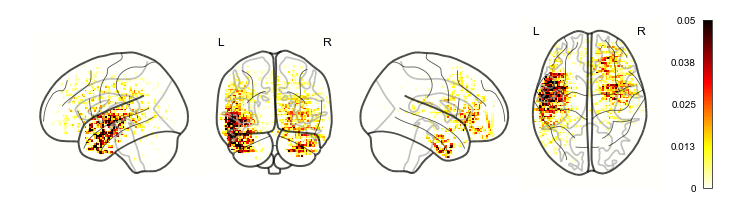

In [33]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.interp_density(fr_locs, np.atleast_2d(density_fr), width=2, vox_size=2, outfile=outfile)

In [34]:
### still same negative correlation with the new way 
rstat = stats.pearsonr(corr_fr_df['Density'], plot.r2z(corr_fr_df['W_a_w']))
print(rstat)

(-0.15121078509849672, 1.864768660724576e-08)


In [35]:
### still same negative correlation with the new way 
rstat = stats.pearsonr(corr_fr_df['Density'], plot.r2z(corr_fr_df['W_w_w']))
print(rstat)

(0.040404702822424705, 0.13497572896813936)


<Figure size 1332x756 with 0 Axes>

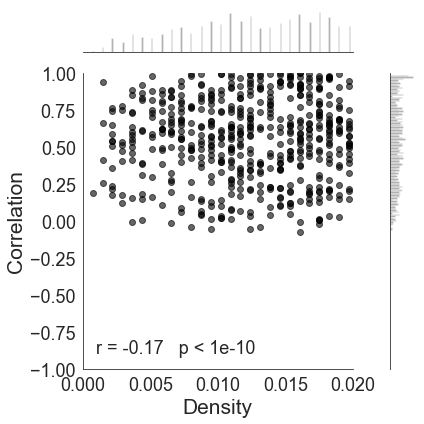

In [36]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot_density(corr_fr_df, 'Density', 'W_a_w', outfile=outfile)

## Find density and correlation across vs within

In [37]:

grouped_results = corr_fr_df.groupby('Subject')['W_a_w','W_w_w'].mean()

pyfr_locs = plot.compile_df_locs(corr_fr_df['R'])
corr_fr_locs = np.atleast_2d(corr_fr_df['W_a_w'])

corr_across_subject = np.array([])
corr_within_subject = np.array([])
R_locs = []
bo_locs = []
subj_by_subject = np.array([])
density_across_fr = np.array([])
density_within_fr = np.array([])

for s in grouped_results.index:


    other_locs = plot.compile_df_locs(corr_fr_df['R'][corr_fr_df['Subject'] != s])
    within_locs = plot.compile_df_locs(corr_fr_df['R'][corr_fr_df['Subject'] == s])
    
    other_tree = spatial.cKDTree(other_locs)
    within_tree = spatial.cKDTree(within_locs)


    bo_locs = []
    
    for l in plot.compile_df_locs(corr_fr_df['R'][corr_fr_df['Subject'] == s]):
    
        if bo_locs == []:
            bo_locs = l 
        else:

            bo_locs = np.vstack((bo_locs, l))
        density_across_fr = np.append(density_across_fr, np.divide(len(other_tree.query_ball_point(l, r)),  other_locs.shape[0]))
        density_within_fr = np.append(density_within_fr, np.divide(len(within_tree.query_ball_point(l, r)), within_locs.shape[0]))

        loc_in_R = se.helpers.get_rows(fr_locs, l)
        
        across_corr = corr_fr_df['W_a_w'].iloc[loc_in_R]
        within_corr = corr_fr_df['W_w_w'].iloc[loc_in_R]
        
        corr_across_subject = np.append(corr_across_subject, across_corr)
        corr_within_subject = np.append(corr_within_subject, within_corr)

    subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(bo_locs)[0]))
    
    if R_locs == []:

        R_locs = bo_locs 

    else:

        R_locs = np.vstack((R_locs, bo_locs))




density_fr_df = pd.DataFrame()
density_fr_df['Correlation_Across'] = plot.r2z(corr_across_subject)
density_fr_df['Correlation_Within'] = plot.r2z(corr_within_subject)
density_fr_df['Density_Across'] = density_across_fr
density_fr_df['Density_Within'] = density_within_fr
density_fr_df['Subject'] = subj_by_subject

In [38]:
rstat = stats.pearsonr(density_fr_df['Density_Across'], density_fr_df['Correlation_Across'] )
print(rstat)

(-0.21645209417149086, 5.470866296457615e-16)


In [39]:
rstat = stats.pearsonr(density_fr_df['Density_Within'], density_fr_df['Correlation_Across'] )
print(rstat)

(0.14759173578177864, 4.065504567968046e-08)


In [40]:
rstat = stats.pearsonr(density_fr_df['Density_Within'], density_fr_df['Correlation_Within'] )
print(rstat)

(0.06496421781438162, 0.01617690941458934)


## plot density for all

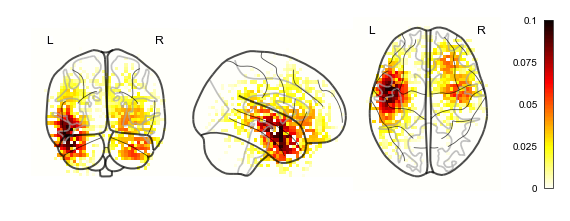

In [41]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_within_r(fr_locs, 20)), locs=fr_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.1, vmin=0)
plt.savefig(outfile)

## plot density across

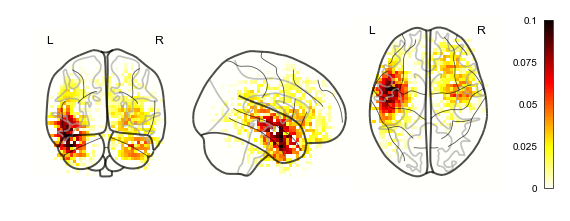

In [42]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_across_fr), locs=R_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.1, vmin=0)
plt.savefig(outfile)

## plot density within

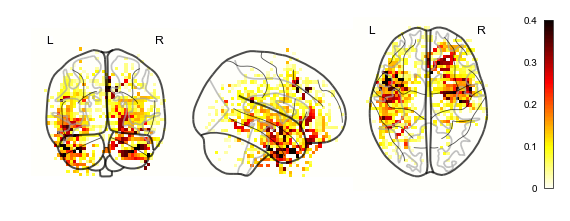

In [43]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_within_fr), locs=R_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.4, vmin=0)
plt.savefig(outfile)

## CatFR

In [44]:
str_find = '_CatFR1_'
str_find
CatFR_df = RAM_df[RAM_df['Subject'].str.contains(str_find)]

In [45]:
catfr_subject = np.array([])
catfr_within = np.array([])
catfr_across = np.array([])
catfr_R = np.array([])
for i , item in enumerate(CatFR_df['Subject'].values):
    #print(item.split('_')[0])
    catfr_subject = np.append(catfr_subject, item.split('_')[0])
    catfr_within = np.append(catfr_within, CatFR_df['W_w_w'].iloc[i])
    catfr_across = np.append(catfr_across, CatFR_df['W_a_w'].iloc[i])
    catfr_R = np.append(catfr_R, CatFR_df['R'].iloc[i])

In [46]:
corr_catfr_df = pd.DataFrame()
corr_catfr_df['Subject'] = catfr_subject
corr_catfr_df['W_w_w'] = catfr_within
corr_catfr_df['W_a_w'] = catfr_across
corr_catfr_df['R'] = catfr_R

In [47]:
catfr_locs = plot.compile_df_locs(corr_catfr_df['R'])
corr_catfr_locs = np.atleast_2d(corr_catfr_df['W_a_w'])

In [48]:
density_catfr = density_within_r(catfr_locs, r)

In [49]:
corr_catfr_df['Density'] = density_catfr

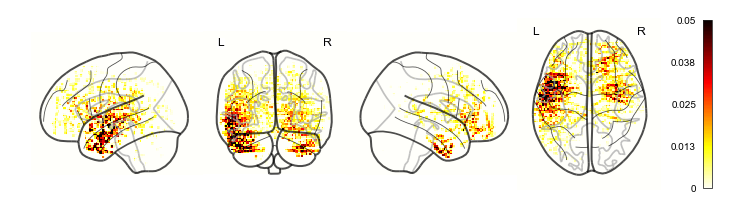

In [50]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.interp_density(catfr_locs, np.atleast_2d(density_catfr), width=2, vox_size=2, outfile=outfile)

In [51]:
### still same negative correlation with the new way 
rstat = stats.pearsonr(corr_catfr_df['Density'], plot.r2z(corr_catfr_df['W_a_w']))
print(rstat)

(-0.16695364153712083, 1.689040488088186e-11)


In [52]:
### still same negative correlation with the new way 
rstat = stats.pearsonr(corr_catfr_df['Density'], plot.r2z(corr_catfr_df['W_w_w']))
print(rstat)

(0.16697493169205774, 1.6789635684798983e-11)


<Figure size 1332x756 with 0 Axes>

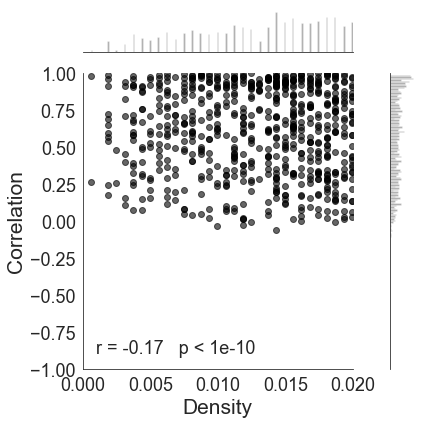

In [53]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot_density(corr_catfr_df, 'Density', 'W_a_w', outfile=outfile)

In [54]:

grouped_results = corr_catfr_df.groupby('Subject')['W_a_w','W_w_w'].mean()

pyfr_locs = plot.compile_df_locs(corr_catfr_df['R'])
corr_catfr_locs = np.atleast_2d(corr_catfr_df['W_a_w'])

corr_across_subject = np.array([])
corr_within_subject = np.array([])
R_locs = []
bo_locs = []
subj_by_subject = np.array([])
density_across_catfr = np.array([])
density_within_catfr = np.array([])

for s in grouped_results.index:



    other_locs = plot.compile_df_locs(corr_catfr_df['R'][corr_catfr_df['Subject'] != s])
    within_locs = plot.compile_df_locs(corr_catfr_df['R'][corr_catfr_df['Subject'] == s])
    
    other_tree = spatial.cKDTree(other_locs)
    within_tree = spatial.cKDTree(within_locs)


    bo_locs = []
    
    for l in plot.compile_df_locs(corr_catfr_df['R'][corr_catfr_df['Subject'] == s]):
    
        if bo_locs == []:
            bo_locs = l 
        else:

            bo_locs = np.vstack((bo_locs, l))

        density_across_catfr = np.append(density_across_catfr, np.divide(len(other_tree.query_ball_point(l, r)), other_locs.shape[0]))
        density_within_catfr = np.append(density_within_catfr, np.divide(len(within_tree.query_ball_point(l, r)), within_locs.shape[0]))

        loc_in_R = se.helpers.get_rows(catfr_locs, l)
        
        across_corr = corr_catfr_df['W_a_w'].iloc[loc_in_R]
        within_corr = corr_catfr_df['W_w_w'].iloc[loc_in_R]
        
        corr_across_subject = np.append(corr_across_subject, across_corr)
        corr_within_subject = np.append(corr_within_subject, within_corr)

    subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(bo_locs)[0]))
    
    if R_locs == []:

        R_locs = bo_locs 

    else:

        R_locs = np.vstack((R_locs, bo_locs))




density_catfr_df = pd.DataFrame()
density_catfr_df['Correlation_Across'] = plot.r2z(corr_across_subject)
density_catfr_df['Correlation_Within'] = plot.r2z(corr_within_subject)
density_catfr_df['Density_Across'] = density_across_catfr
density_catfr_df['Density_Within'] = density_within_catfr
density_catfr_df['Subject'] = subj_by_subject

In [55]:
rstat = stats.pearsonr(density_catfr_df['Density_Across'], density_catfr_df['Correlation_Across'] )
print(rstat)

(-0.22638904128160442, 4.2276943520140323e-20)


In [56]:
rstat = stats.pearsonr(density_catfr_df['Density_Within'], density_catfr_df['Correlation_Across'] )
print(rstat)

(0.1273182326226893, 3.095376824441433e-07)


In [57]:
rstat = stats.pearsonr(density_catfr_df['Density_Within'], density_catfr_df['Correlation_Within'] )
print(rstat)

(0.18561482555021738, 6.598712732608156e-14)


## plot density for all

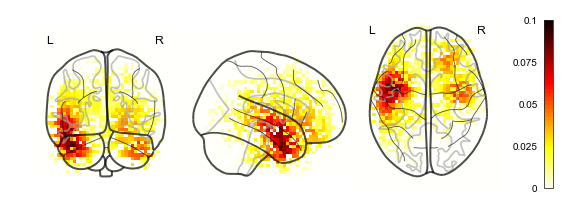

In [58]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_within_r(catfr_locs, 20)), locs=catfr_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.1, vmin=0)
plt.savefig(outfile)

## plot density across

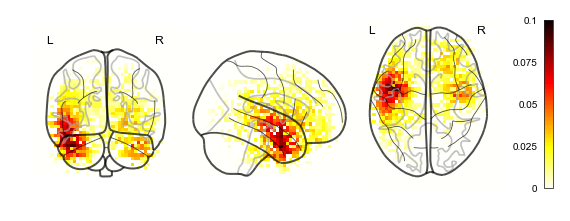

In [59]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_across_catfr), locs=R_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.1, vmin=0)
plt.savefig(outfile)

## plot density within

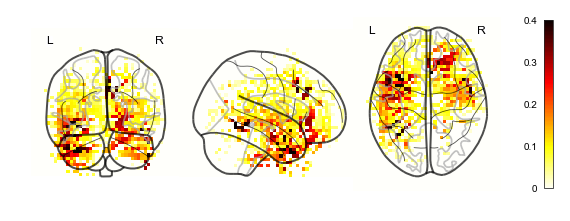

In [60]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_within_catfr), locs=R_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.4, vmin=0)
plt.savefig(outfile)

## Across

In [61]:
A_a_a = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/across/a_sub-a_exp.csv', index_col=0)
A_a_a.name = 'A_a_a'
A_a_all = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/across/a_sub-all_exp.csv', index_col=0)
A_a_all.name = 'A_a_all'
A_a_w = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/across/a_sub-w_exp.csv', index_col=0)
A_a_w.name = 'A_a_w'
A_w_a = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/across/w_sub-a_exp.csv', index_col=0)
A_w_a.name = 'A_w_a'
A_w_all = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/across/w_sub-all_exp.csv', index_col=0)
A_w_all.name = 'A_w_all'
A_w_w = pd.read_csv('/Users/lucyowen/Desktop/paper_figures/ram/across/w_sub-w_exp.csv', index_col=0)
A_w_w.name = 'A_w_w'

In [62]:
dfs_2 = [A_a_a, A_a_all, A_a_w, A_w_w]

In [63]:
RAM_df_2 = dfs_2[0]
RAM_df_2 = RAM_df_2.rename(columns={"Correlation":RAM_df_2.name})
for df_ in dfs_2[1:]:
    RAM_df_2 = RAM_df_2.merge(df_, on=['Subject', 'R'])
    RAM_df_2 = RAM_df_2.rename(columns={"Correlation":df_.name})

In [64]:
RAM_df_2.dropna(inplace=True)

In [65]:
ram_subject = np.array([])
ram_within = np.array([])
ram_across = np.array([])
ram_R = np.array([])
for i , item in enumerate(RAM_df_2['Subject'].values):
    #print(item.split('_')[0])
    ram_subject = np.append(ram_subject, item.split('_')[0])
    ram_within = np.append(ram_within, RAM_df_2['A_w_w'].iloc[i])
    ram_across = np.append(ram_across, RAM_df_2['A_a_w'].iloc[i])
    ram_R = np.append(ram_R, RAM_df_2['R'].iloc[i])

In [66]:
corr_ram_df = pd.DataFrame()
corr_ram_df['Subject'] = ram_subject
corr_ram_df['A_w_w'] = ram_within
corr_ram_df['A_a_w'] = ram_across
corr_ram_df['R'] = ram_R

In [67]:
ram_locs = plot.compile_df_locs(corr_ram_df['R'])
corr_ram_locs = np.atleast_2d(corr_ram_df['A_a_w'])

In [68]:
density_ram = density_within_r(ram_locs, r)

In [69]:
corr_ram_df['Density'] = density_ram

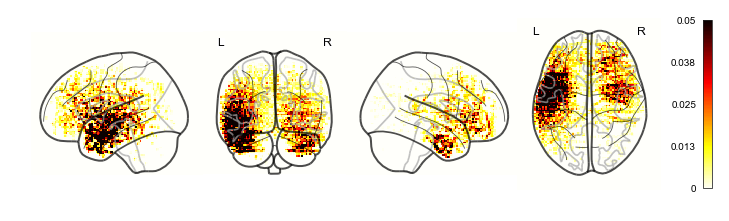

In [70]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.interp_density(ram_locs, np.atleast_2d(density_ram), width=2, vox_size=2, outfile=outfile)

In [71]:
### still same negative correlation with the new way 
rstat = stats.pearsonr(corr_ram_df['Density'], plot.r2z(corr_ram_df['A_a_w']))
print(rstat)

(-0.24420522983868193, 7.521281869097711e-69)


In [72]:
### still same negative correlation with the new way 
rstat = stats.pearsonr(corr_ram_df['Density'], plot.r2z(corr_ram_df['A_w_w']))
print(rstat)

(0.05127438815210787, 0.0002849873305840645)


<Figure size 1332x756 with 0 Axes>

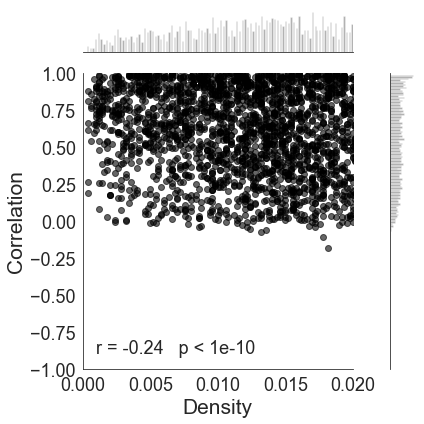

In [73]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot_density(corr_ram_df, 'Density', 'A_a_w', outfile=outfile)

In [74]:

grouped_results = corr_ram_df.groupby('Subject')['A_a_w','A_w_w'].mean()

ram_locs = plot.compile_df_locs(corr_ram_df['R'])
corr_ram_locs = np.atleast_2d(corr_ram_df['A_a_w'])

corr_across_subject = np.array([])
corr_within_subject = np.array([])
R_locs = []
bo_locs = []
subj_by_subject = np.array([])
density_across_ram = np.array([])
density_within_ram = np.array([])

for s in grouped_results.index:


    other_locs = plot.compile_df_locs(corr_ram_df['R'][corr_ram_df['Subject'] != s])
    within_locs = plot.compile_df_locs(corr_ram_df['R'][corr_ram_df['Subject'] == s])
    
    other_tree = spatial.cKDTree(other_locs)
    within_tree = spatial.cKDTree(within_locs)

    bo_locs = []
    
    for l in plot.compile_df_locs(corr_ram_df['R'][corr_ram_df['Subject'] == s]):
    
        if bo_locs == []:
            bo_locs = l 
        else:

            bo_locs = np.vstack((bo_locs, l))

        density_across_ram = np.append(density_across_ram, np.divide(len(other_tree.query_ball_point(l, r)), other_locs.shape[0]))
        density_within_ram = np.append(density_within_ram, np.divide(len(within_tree.query_ball_point(l, r)), within_locs.shape[0]))

        loc_in_R = se.helpers.get_rows(ram_locs, l)
        
        across_corr = corr_ram_df['A_a_w'].iloc[loc_in_R]
        within_corr = corr_ram_df['A_w_w'].iloc[loc_in_R]
        
        corr_across_subject = np.append(corr_across_subject, across_corr)
        corr_within_subject = np.append(corr_within_subject, within_corr)

    subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(bo_locs)[0]))
    
    if R_locs == []:

        R_locs = bo_locs 

    else:

        R_locs = np.vstack((R_locs, bo_locs))




density_ram_df = pd.DataFrame()
density_ram_df['Correlation_Across'] = plot.r2z(corr_across_subject)
density_ram_df['Correlation_Within'] = plot.r2z(corr_within_subject)
density_ram_df['Density_Across'] = density_across_ram
density_ram_df['Density_Within'] = density_within_ram
density_ram_df['Subject'] = subj_by_subject

In [75]:
rstat = stats.pearsonr(density_ram_df['Density_Across'], density_ram_df['Correlation_Across'] )
print(rstat)

(-0.26784759006263664, 5.785964537972247e-83)


In [76]:
rstat = stats.pearsonr(density_ram_df['Density_Within'], density_ram_df['Correlation_Across'] )
print(rstat)

(0.11211565005622628, 1.8050996339031833e-15)


In [77]:
rstat = stats.pearsonr(density_ram_df['Density_Within'], density_ram_df['Correlation_Within'] )
print(rstat)

(0.08415411386638465, 2.4907038100848715e-09)


## plot density for all

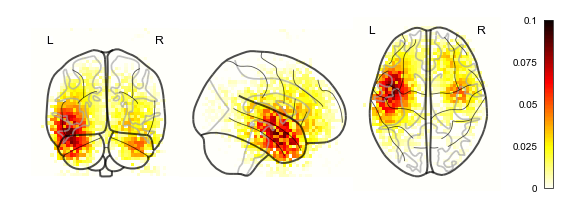

In [78]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_within_r(ram_locs, 20)), locs=ram_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.1, vmin=0)
plt.savefig(outfile)

## plot density across

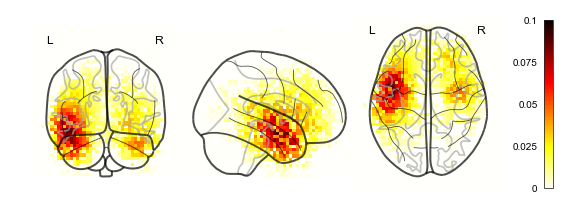

In [79]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_across_ram), locs=R_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.1, vmin=0)
plt.savefig(outfile)

## plot density within

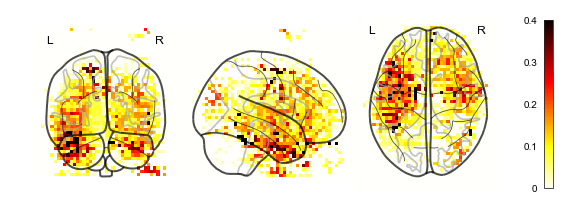

In [80]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_within_ram), locs=R_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.4, vmin=0)
plt.savefig(outfile)